In [1]:
#----------------------------------------------
# Stefano Piacentini - 05/02/2020
#----------------------------------------------

library(rjags)

Loading required package: coda

Linked to JAGS 4.3.0

Loaded modules: basemod,bugs



In [2]:
# Definition of saewtooth function
rate_sim = function(x, rx, 
                    A = 0.,
                    v = 1.,
                    phi = 0. * pi,
                    B = 0.,
                    SAW = 0) {
    
#    N_windows <- nrow(timewindows)
#    
#    timewindows_norm <- timewindows / 365
#    center <- (timewindows_norm[2] - timewindows_norm[1] )/ 2 + timewindows_norm[1]
    
#    ret <- 0
#    
#    for (i in 1:N_windows) {
#        if (x > timewindows_norm[i,1] && x < timewindows_norm[i,2]) {
#            x_0 <- center[i,1]
            ret <- A * cos(2 * pi * x / v + phi) + SAW * B * ( rx )
#            break
#        }
#    }
    return(ret)
} 

In [3]:
# Definition of the function return the right rescaled time
resc_t = function(x, timewindows) {
    
    N_windows <- nrow(timewindows)
    
    timewindows_norm <- timewindows / 365
    center <- (timewindows_norm[2] - timewindows_norm[1] )/ 2 + timewindows_norm[1]
    
    ret <- 0
    
    for (i in 1:N_windows) {
        if (x > timewindows_norm[i,1] && x < timewindows_norm[i,2]) {
#            print(x)
            x_0 <- center[i,1]
#            print(x_0)
            ret <- (x-x_0)
            break
        }
    }
    return(ret)
} 

In [4]:
# Loading time windows
timewindows <- read.table("timewindows.txt")

In [5]:
#rate_sim = function(x,
#                    A = 0.,
#                    v = 1.,
#                    phi = 0. * pi,
#                    B = 0.01,
#                    SAW = 0) {
#    ret <- A * cos(2 * pi * x / v + phi) -SAW * (B*v)/2. + SAW *B * ((x+0.15) %%v)
#    return(ret)
#}

In [6]:
dataframe <- read.table("dama_3.txt")

N_r <- nrow(dataframe)
t_real <- rep(1, N_r)
ren_t  <- rep(1, N_r)
x_real <- rep(1, N_r)
sd_real <- rep(1, N_r)

for (i in 1:N_r) {
    t_real[i] <- dataframe[i, 1]
    x_real[i] <- dataframe[i, 2]
    
    # dev std media a occhio dai plot
    if (t_real[i] <= 3000) {
        sd_real[i] <- 0.030/2
    } else if (t_real[i]< 5800 && t_real[i] > 3000) {
        sd_real[i] <- 0.015/2
    } else if (t_real[i]>= 5800) {
        sd_real[i] <- 0.009/2/0.8
    }
    
}
ren_t <- (t_real)/365

#rescaled time

time_resc <- rep(0, length(ren_t))
for(i in 1:length(time_resc)) {
    time_resc[i] <- resc_t(ren_t[i], timewindows)
}

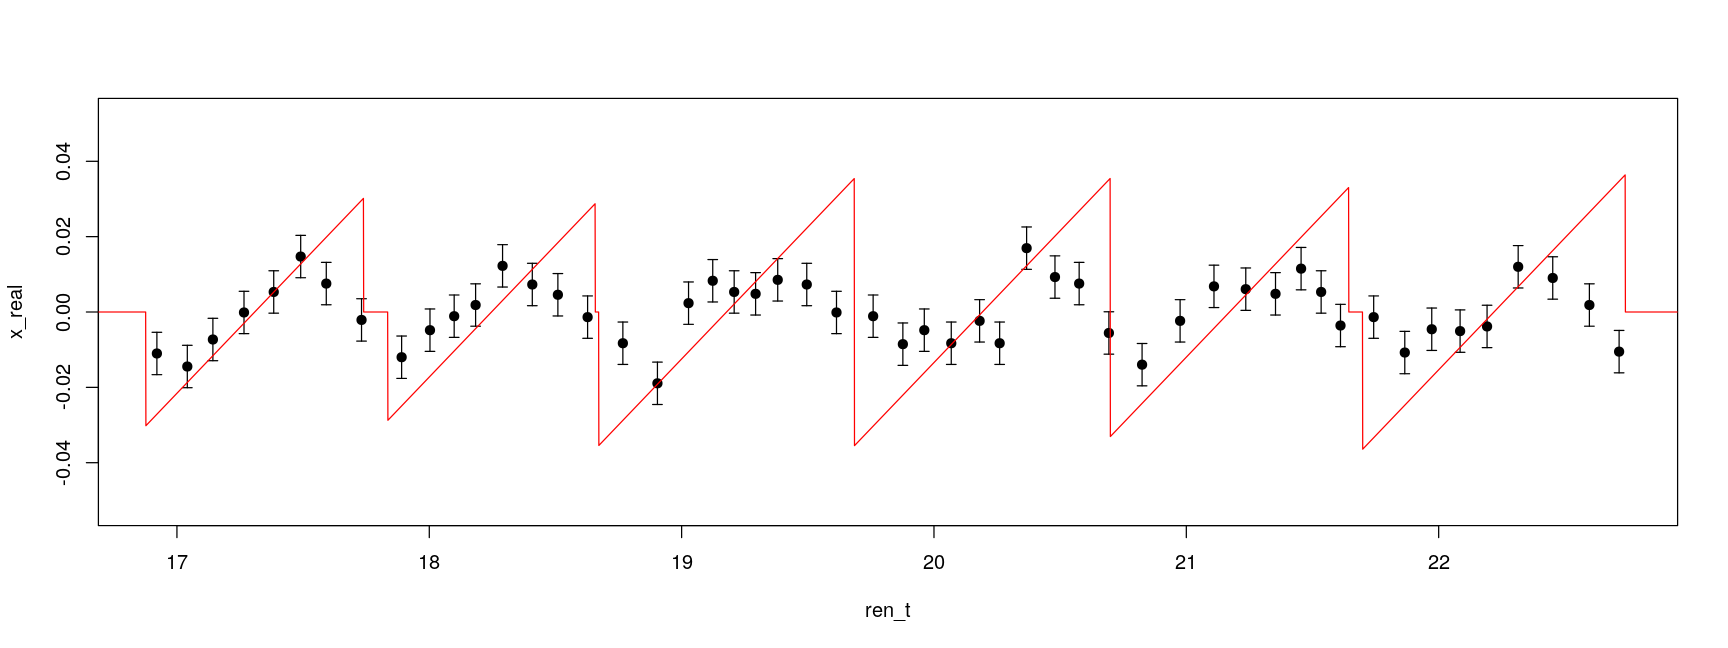

In [7]:
options(repr.plot.width=8*1.8, repr.plot.height=3*1.8)

plot(ren_t, x_real,
    pch=19, ylim = c(-1.5 * 0.035 , 1.5 * 0.035)
)
arrows(ren_t, x_real-sd_real, ren_t, x_real+sd_real, length=0.04, angle=90, code=3)

tmp <- seq(16., 25., by = 1e-3)
vec <- seq(16., 25., by = 1e-3)

for (i in 1:length(tmp)) {
    vec[i] <- resc_t(tmp[i], timewindows)  
}

# Just an example (NOT THE FIT)
vec <- rate_sim(x = tmp, rx= vec, SAW = 1,
                    A   = 0.,
                    phi = 0.0,
                    B   = 0.07,
                   )

lines(tmp, vec, col = 'red')

Warning message in jags.model(modello_cos, fitInput_r_cos, model_cos_init):
“Unused variable "ft" in data”
Warning message in jags.model(modello_cos, fitInput_r_cos, model_cos_init):
“Unused variable "max_A" in data”
Warning message in jags.model(modello_cos, fitInput_r_cos, model_cos_init):
“Unused variable "max_phi" in data”
Warning message in jags.model(modello_cos, fitInput_r_cos, model_cos_init):
“Unused variable "width_B" in data”


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 52
   Unobserved stochastic nodes: 1
   Total graph size: 427

Initializing model


Iterations = 11001:21000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

          Mean             SD       Naive SE Time-series SE 
     9.205e-03      1.129e-03      1.129e-05      1.419e-05 

2. Quantiles for each variable:

    2.5%      25%      50%      75%    97.5% 
0.007010 0.008445 0.009218 0.009967 0.011431 



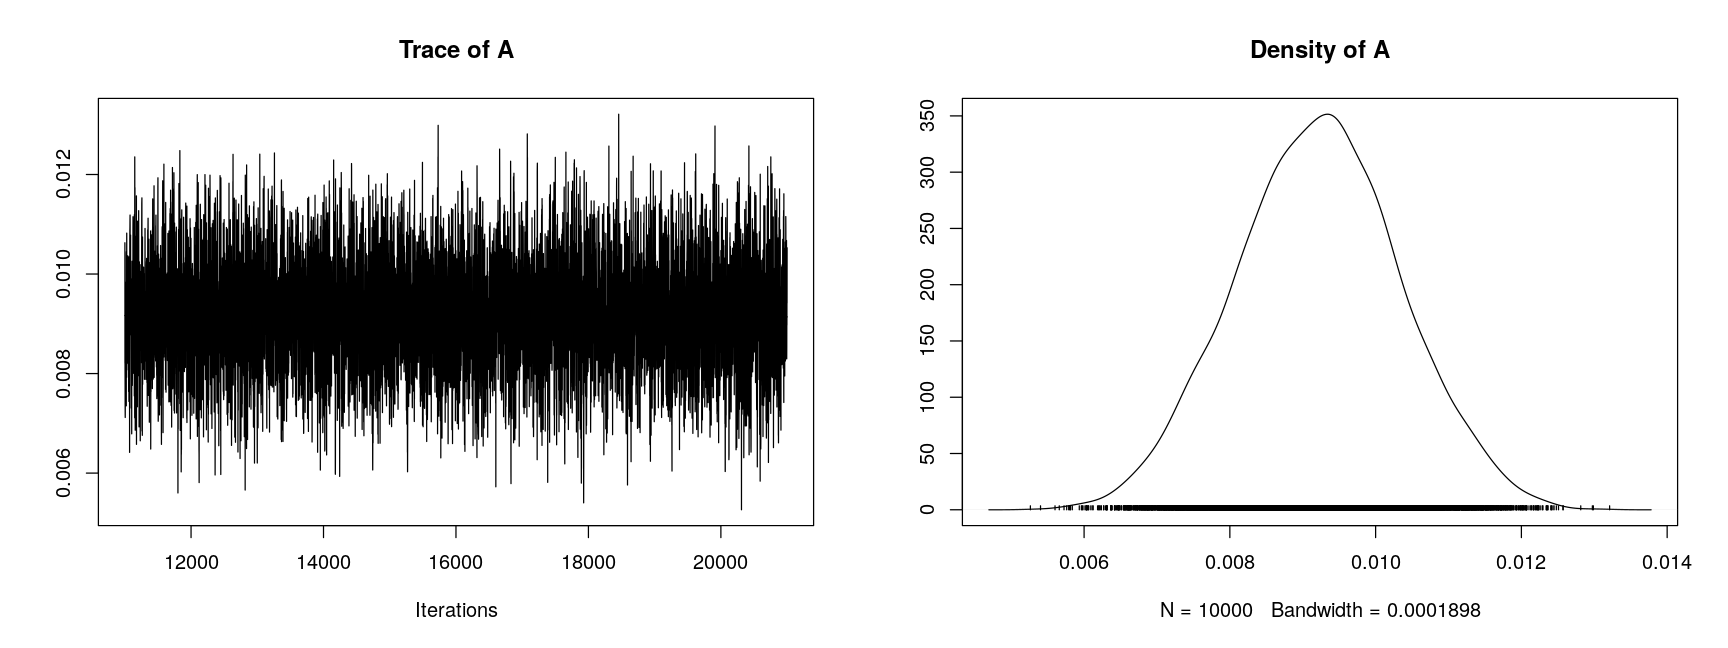

In [8]:
# FIT OF THE REAL DATA WITH COS


# Setting parameters for unif. priors
max_Acos     <- 0.05
max_Bcos     <- 0.03
max_phicos   <- 2 * pi
sc_A         <- 0.05


modello_cos    <-    "COSfix.bug" # file con modello di puro segnale

#model_cos_init    <- list(A = 0.02, phi = 3.801730)
model_cos_init    <- list(A = 0.02)

fitInput_r_cos <- NULL

fitInput_r_cos$n      <- N_r
fitInput_r_cos$x      <- x_real
fitInput_r_cos$sd     <- sd_real
fitInput_r_cos$t      <- ren_t
fitInput_r_cos$ft     <- floor(ren_t+0.15)
fitInput_r_cos$v      <- 1
fitInput_r_cos$pi     <- pi
fitInput_r_cos$phi    <- 3.801730
fitInput_r_cos$sc_A   <- sc_A

    
# prior parameters
fitInput_r_cos$max_A   <- max_Acos
fitInput_r_cos$max_phi <- max_phicos
fitInput_r_cos$width_B   <- max_Bcos

    
m_cos_r <- jags.model(modello_cos,
                    fitInput_r_cos,
                    model_cos_init
                   )

update(m_cos_r, 10000)                  # burn in 

#to.sample_cos_r = c('A', 'phi')
to.sample_cos_r = c('A')

catena_cos_r <- coda.samples(m_cos_r, to.sample_cos_r, n.iter=10000)  # sampling 
    
mcmc_cos_r <- as.mcmc(catena_cos_r)

print(summary(catena_cos_r))

plot(catena_cos_r)

Warning message in jags.model(modello_saw, fitInput_r_saw, model_saw_init):
“Unused variable "max_A" in data”
Warning message in jags.model(modello_saw, fitInput_r_saw, model_saw_init):
“Unused variable "max_phi" in data”
Warning message in jags.model(modello_saw, fitInput_r_saw, model_saw_init):
“Unused variable "sc_B" in data”


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 52
   Unobserved stochastic nodes: 2
   Total graph size: 584

Initializing model


Iterations = 11001:21000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

      Mean       SD  Naive SE Time-series SE
A 0.008454 0.001250 1.250e-05      2.014e-05
B 0.002788 0.002179 2.179e-05      4.161e-05

2. Quantiles for each variable:

       2.5%      25%      50%      75%    97.5%
A 5.998e-03 0.007608 0.008469 0.009282 0.010912
B 9.795e-05 0.001061 0.002300 0.004024 0.008077



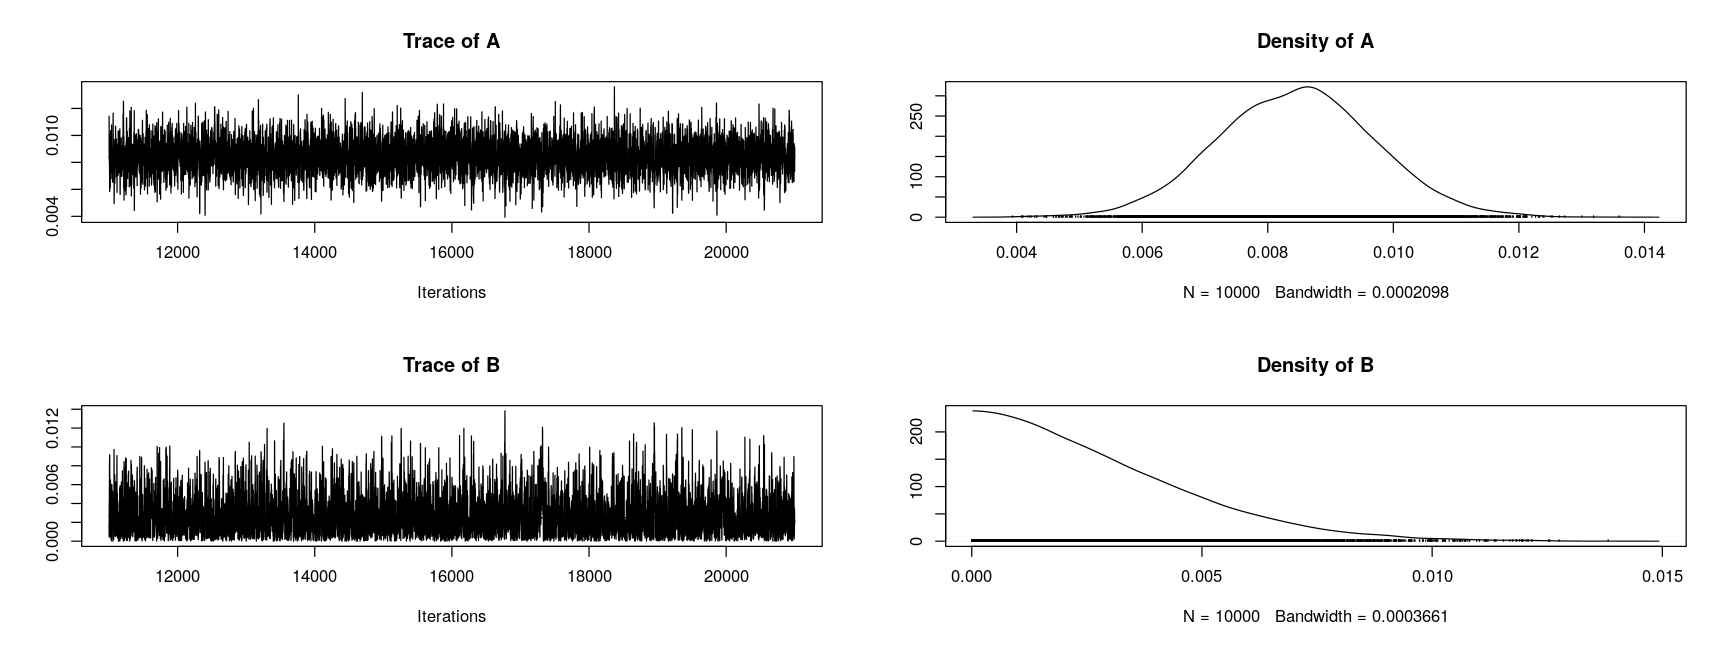

In [9]:
# FIT OF THE REAL DATA WITH SAWCOS


# Setting parameters for unif. priors
#B_0saw       <- 0.02
#max_Asaw     <- 0.00001
#width_Bsaw   <- 0.02
#max_phisaw   <- 0.0001
max_Asaw     <- 0.05
max_Bsaw     <- 0.1
sc_B         <- 0.1
sc_A         <- 0.05/2
max_phisaw   <- 2 * pi

modello_saw    <-    "SAWCOS.bug" # file con modello di puro segnale

model_saw_init    <- list(A = 0.02, B = 0.01)
#model_saw_init    <- list(A = 0., B = 0.01)

fitInput_r_saw <- NULL

fitInput_r_saw$n      <- N_r
fitInput_r_saw$x      <- x_real
fitInput_r_saw$sd     <- sd_real
fitInput_r_saw$t      <- ren_t
fitInput_r_saw$ft     <- time_resc
fitInput_r_saw$v      <- 1
fitInput_r_saw$pi     <- pi
fitInput_r_saw$phi    <- 3.801730

    
# prior parameters
fitInput_r_saw$max_A   <- max_Asaw
fitInput_r_saw$max_phi <- max_phisaw
fitInput_r_saw$max_B   <- max_Bsaw
fitInput_r_saw$sc_A    <- sc_A
fitInput_r_saw$sc_B    <- sc_B

    
m_saw_r <- jags.model(modello_saw,
                    fitInput_r_saw,
                    model_saw_init
                   )

update(m_saw_r, 10000)                  # burn in 

to.sample_saw_r = c('A', 'B')

catena_saw_r <- coda.samples(m_saw_r, to.sample_saw_r, n.iter=10000)  # sampling 
    
mcmc_saw_r <- as.mcmc(catena_saw_r)

print(summary(catena_saw_r))

plot(catena_saw_r)

Warning message in jags.model(modello_osaw, fitInput_r_osaw, model_osaw_init):
“Unused variable "t" in data”
Warning message in jags.model(modello_osaw, fitInput_r_osaw, model_osaw_init):
“Unused variable "v" in data”
Warning message in jags.model(modello_osaw, fitInput_r_osaw, model_osaw_init):
“Unused variable "pi" in data”
Warning message in jags.model(modello_osaw, fitInput_r_osaw, model_osaw_init):
“Unused variable "max_A" in data”
Warning message in jags.model(modello_osaw, fitInput_r_osaw, model_osaw_init):
“Unused variable "max_phi" in data”
Warning message in jags.model(modello_osaw, fitInput_r_osaw, model_osaw_init):
“Unused variable "sc_B" in data”


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 52
   Unobserved stochastic nodes: 1
   Total graph size: 214

Initializing model


Iterations = 11001:21000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

          Mean             SD       Naive SE Time-series SE 
     1.496e-02      2.827e-03      2.827e-05      3.853e-05 

2. Quantiles for each variable:

   2.5%     25%     50%     75%   97.5% 
0.00947 0.01305 0.01498 0.01686 0.02044 



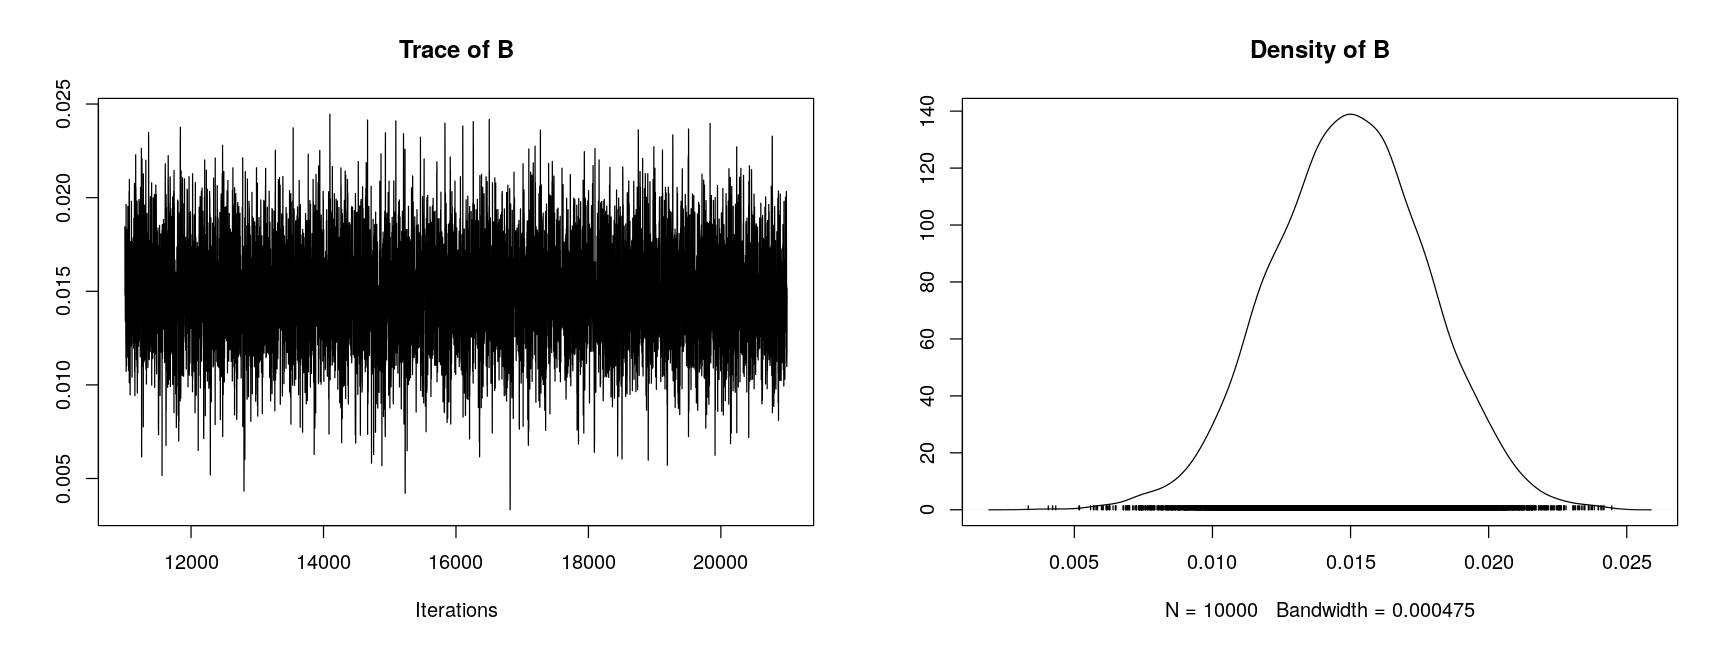

In [10]:
    # FIT OF THE REAL DATA WITH ONLYSAW


# Setting parameters for unif. priors
#B_0saw       <- 0.02
#max_Asaw     <- 0.00001
#width_Bsaw   <- 0.02
#max_phisaw   <- 0.0001
max_Aosaw     <- 0.05
max_Bosaw     <- 0.1
sc_B          <- 0.1
max_phiosaw   <- 2 * pi


modello_osaw    <-    "ONLYSAW.bug" # file con modello di puro segnale

#model_saw_init    <- list(A = 0.02, B = 0.01, phi = pi/4)
model_osaw_init    <- list(B = 0.01)


fitInput_r_osaw <- NULL

fitInput_r_osaw$n      <- N_r
fitInput_r_osaw$x      <- x_real
fitInput_r_osaw$sd     <- sd_real
fitInput_r_osaw$t      <- ren_t
fitInput_r_osaw$ft     <- time_resc
fitInput_r_osaw$v      <- 1
fitInput_r_osaw$pi     <- pi
    
# prior parameters
fitInput_r_osaw$max_A   <- max_Aosaw
fitInput_r_osaw$max_phi <- max_phiosaw
fitInput_r_osaw$max_B   <- max_Bosaw
fitInput_r_osaw$sc_B    <- sc_B

    
m_osaw_r <- jags.model(modello_osaw,
                    fitInput_r_osaw,
                    model_osaw_init
                   )

update(m_osaw_r, 10000)                  # burn in 

to.sample_osaw_r = c('B')

catena_osaw_r <- coda.samples(m_osaw_r, to.sample_osaw_r, n.iter=10000)  # sampling 
    
mcmc_osaw_r <- as.mcmc(catena_osaw_r)

print(summary(catena_osaw_r))

plot(catena_osaw_r)

In [11]:
# First rough extimations of odds factors

    l_cos_r <- 1
    for (j in 1:N_r) {
        l_cos_r <- l_cos_r * dnorm(x_real[j],
                                         mean = rate_sim(ren_t[j],time_resc[j],
                                                         SAW = 0,
                                                         A   = mean(mcmc_cos_r[,"A"]),
                                                         phi = 3.801730                                                         
                                                        ),
                                         sd = sd_real[j])
    }
    l_saw_r <- 1
    for (j in 1:N_r) {
        l_saw_r <- l_saw_r * dnorm(x_real[j],
                                         mean = rate_sim(ren_t[j], time_resc[j],
                                                         SAW = 1,
                                                         A   = mean(mcmc_saw_r[,"A"]),
                                                         phi = 3.801730,
                                                         B   = mean(mcmc_saw_r[,"B"])),
                                         sd = sd_real[j])
    }

    l_osaw_r <- 1
    for (j in 1:N_r) {
        l_osaw_r <- l_osaw_r * dnorm(x_real[j],
                                         mean = rate_sim(ren_t[j], time_resc[j],
                                                         SAW = 1,
                                                         A   = 0,
                                                         phi = 3.801730,
                                                         B   = mean(mcmc_osaw_r[,"B"])),
                                         sd = sd_real[j])
    }
    
   
    
    ock_cos_r <- sqrt(2*pi)^(1)*sd(mcmc_cos_r[,"A"])*dgamma(mean(mcmc_cos_r[,"A"]),1,1/sc_A);
    
    ock_saw_r <- sqrt(2*pi)^(2)*sd(mcmc_saw_r[,"A"])*dgamma(mean(mcmc_saw_r[,"A"]),1,1/sc_A)*
                                   sd(mcmc_saw_r[,"B"])/(max_Bsaw);
    #ock_saw_r <- sqrt(2*pi)^(2)*sd(mcmc_saw_r[,"A"])*
    #                               sd(mcmc_saw_r[,"B"])/(max_Bsaw*max_Asaw);
    
    ock_osaw_r <- sqrt(2*pi)^(1)*sd(mcmc_osaw_r[,"B"])/(max_Bosaw);
    
    
    O12_r <- (l_cos_r * ock_cos_r)/(l_saw_r*ock_saw_r);
    O21_r <- 1/O12_r

    
    O13_r <- (l_cos_r * ock_cos_r)/(l_osaw_r*ock_osaw_r);
    O31_r <- 1/O13_r

    
    O32_r <- (l_osaw_r * ock_osaw_r)/(l_saw_r*ock_saw_r);
    O23_r <- 1/O32_r

In [12]:
# Odds ratios for data generated from cos modulations
O13_r
O31_r

[1] 660333333

[1] 1.514387e-09

In [13]:
ock_cos_r
ock_osaw_r
10 * log10(ock_cos_r/ock_osaw_r)
10 * log10(ock_cos_r/ock_saw_r)
10 * log10(ock_saw_r/ock_osaw_r)

[1] 0.07836294

[1] 0.07086544

[1] 0.4367623

[1] 12.05385

[1] -11.61708

In [14]:
log(l_cos_r)
log(l_osaw_r)
10*log10(l_cos_r/l_osaw_r)
10*log10(l_cos_r/l_saw_r)
10*log10(l_saw_r/l_osaw_r)

[1] 201.0348

[1] 180.8272

[1] 87.76087

[1] 1.923005

[1] 85.83786

In [15]:
# Computing the CHI2

#tmpx = rate_sim(ren_t, SAW = 0,
#                    A   = mean(mcmc_cos_r[,"A"]),
#                    phi = mean(mcmc_cos_r[,"phi"])
#                   )
#sum((x_real - tmpx)^2 / ((sd_real)^2))
#tmpx = rate_sim(ren_t, SAW = 1,
#                    A   = mean(mcmc_saw_r[,"A"]),
#                    B   = mean(mcmc_saw_r[,"B"]),
#                    phi = mean(mcmc_saw_r[,"phi"])
#                   )
#sum((x_real - tmpx)^2 / ((sd_real)^2))

chi2_cos =- 2 * ( log(l_cos_r) - sum(log(1/(sqrt(2*pi*sd_real^2)))))
print(chi2_cos)
chi2_saw =- 2 * ( log(l_saw_r) - sum(log(1/(sqrt(2*pi*sd_real^2)))))
print(chi2_saw)
chi2_osaw =- 2 * ( log(l_osaw_r) - sum(log(1/(sqrt(2*pi*sd_real^2)))))
print(chi2_osaw)
print(N_r)

[1] 41.13628
[1] 42.02186
[1] 81.55166
[1] 52


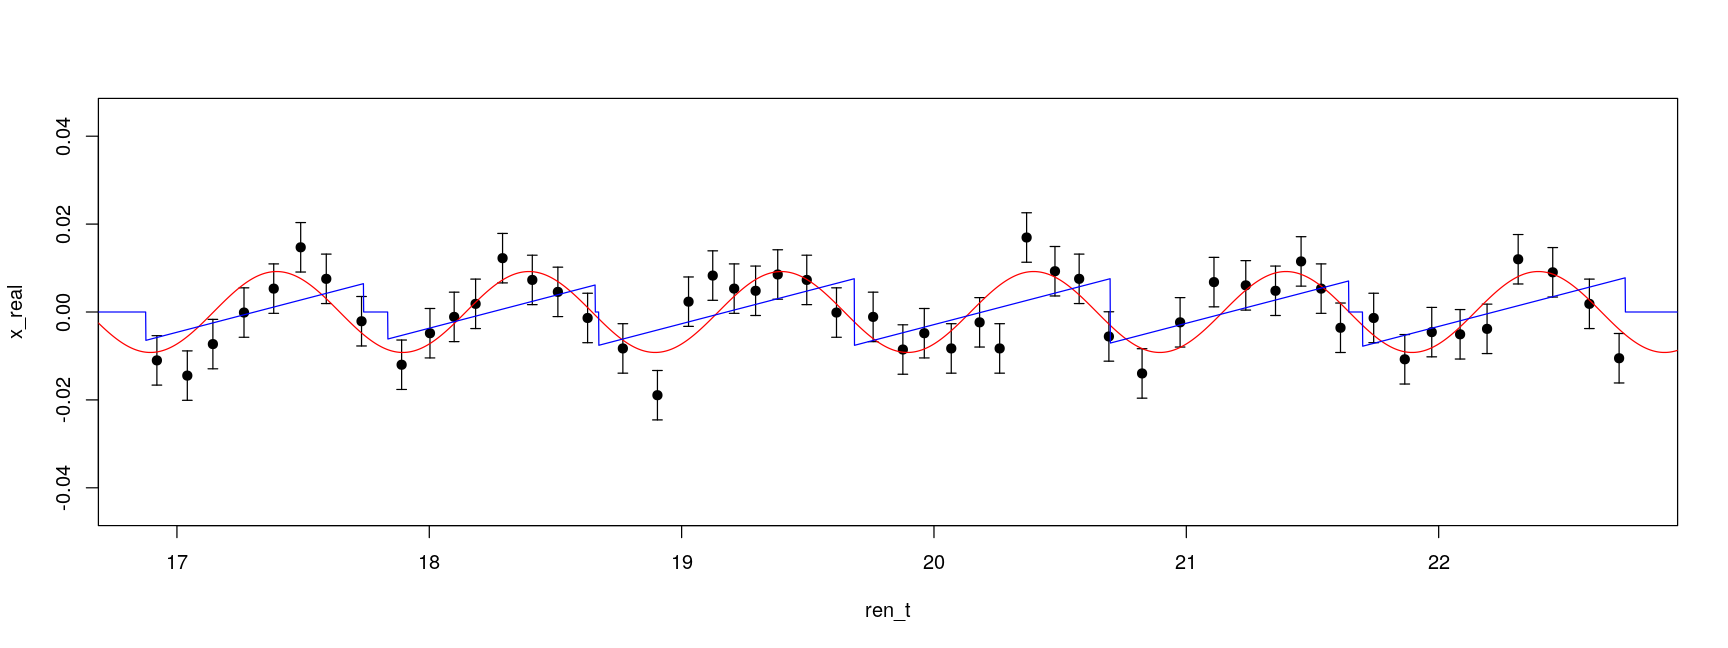

In [16]:
options(repr.plot.width=8*1.8, repr.plot.height=3*1.8)

plot(ren_t, x_real,
    pch=19, ylim = c(-1.5 * 0.03 , 1.5 * 0.03)
)
arrows(ren_t, x_real-sd_real, ren_t, x_real+sd_real, length=0.04, angle=90, code=3)

tmp <- seq(16., 25., by = 1e-3)
tr  <- seq(16., 25., by = 1e-3)

for (i in 1:length(tmp)) {
    tr[i] <- resc_t(tmp[i], timewindows)  
}

vec_cos <- rate_sim(x = tmp, rx= tr, SAW = 0,
                    A   = mean(mcmc_cos_r[,"A"]),
                    phi = 3.801730
                   )

vec_osaw <- rate_sim(x = tmp, rx= tr, SAW = 1,
                    A   = 0,
                    phi = 0,
                    B   = mean(mcmc_osaw_r[,"B"])
                   )

lines(tmp, vec_cos, col = 'red')
lines(tmp, vec_osaw,col= 'blue')


#lines(tmp, rate_sim(tmp, SAW = 0,
#                    A   = mean(mcmc_cos_r[,"A"]),
#                    phi = mean(mcmc_cos_r[,"phi"])
#                   ), col = 'red')
#lines(tmp, rate_sim(tmp, SAW = 1,
#                    A   = mean(mcmc_saw_r[,"A"]),
#                    phi = mean(mcmc_saw_r[,"phi"]),
#                    B   = mean(mcmc_saw_r[,"B"])
#                   ), col = 'blue')
#lines(tmp, rate_sim(tmp, SAW = 1,
#                    A   = 0,
#                    phi = 0,
#                    B   = mean(mcmc_osaw_r[,"B"])
#                   ), col = 'green')
#tmp2 <- 0*tmp
#lines(tmp, tmp2, col= 'green')

In [17]:
library(bridgesampling)
library(R2jags)
library(mcmcplots)


Attaching package: ‘R2jags’


The following object is masked from ‘package:coda’:

    traceplot


Registered S3 method overwritten by 'mcmcplots':
  method        from  
  as.mcmc.rjags R2jags



In [18]:
### functions for evaluating the unnormalized posteriors on log scale ###


log_posterior_cos <- function(pars, data) {
      
      
  A   <- pars["A"]
#  phi <- pars["phi"]

    
  sig <- A * cos(2. * pi * data$t / data$v + data$phi )


  out <-
          dgamma(A, 1, 1/data$sc_A, log = TRUE) + 
#      dunif(A, 0.0, data$max_A, log = TRUE) +          # prior
#      dunif(phi, 0.0, data$max_phi, log = TRUE) +      # prior
      sum(dnorm(data$x, sig, data$sd, log = TRUE))       # likelihood

 return(out)  
}



In [19]:
### functions for evaluating the unnormalized posteriors on log scale ###


log_posterior_saw <- function(pars, data) {
      
      
  A   <- pars["A"]
  B   <- pars["B"]
#  phi <- pars["phi"]

    
  sig <- A * cos(2. * pi * data$t / data$v + data$phi )
  bkg <- -B * (data$ft)

    out <-
      dgamma(A, 1, 1/data$sc_A, log = TRUE) + 
#      dunif(A, 0.0, data$max_A, log = TRUE) +          # prior
      dunif(B, 0, data$max_B, log = TRUE) +          # prior
#      dunif(phi, 0.0, data$max_phi, log = TRUE) +      # prior
      sum(dnorm(data$x, sig+bkg, data$sd, log = TRUE))       # likelihood

 return(out)  
}

In [20]:
### functions for evaluating the unnormalized posteriors on log scale ###


log_posterior_osaw <- function(pars, data) {
      
      
  B   <- pars["B"]

    
  bkg <-  B * (data$ft)

    out <-
      dunif(B, 0., 0.+ data$max_B, log = TRUE) +          # prior
      sum(dnorm(data$x, bkg, data$sd, log = TRUE))       # likelihood

 return(out)  
}

In [21]:
# specify parameter bounds for cos
#cn <- c("A", "phi")
cn <- c('A')
lb_cos <- rep(0, length(cn))
ub_cos <- rep(0, length(cn))
names(lb_cos) <- names(ub_cos) <- cn
#lb_cos["phi"] = 0.0
#ub_cos["phi"] = fitInput_r_cos$max_phi
lb_cos["A"] = 0.0 
#ub_cos["A"] = fitInput_r_cos$sc_A
ub_cos["A"] = fitInput_r_cos$max_A

In [22]:
# specify parameter bounds for cos
cn <- c("A", "B")
lb_saw <- rep(0, length(cn))
ub_saw <- rep(0, length(cn))
names(lb_saw) <- names(ub_saw) <- cn
#lb_saw["phi"] = 0.0
#ub_saw["phi"] = fitInput_r_saw$max_phi
lb_saw["A"] = 0.0 
ub_saw["A"] = fitInput_r_saw$sc_A
lb_saw["B"] = 0
ub_saw["B"] = fitInput_r_saw$max_B 


In [23]:
# specify parameter bounds for cos
cn <- c("B")
lb_osaw <- rep(0, length(cn))
ub_osaw <- rep(0, length(cn))
names(lb_osaw) <- names(ub_osaw) <- cn
lb_osaw["B"] = 0. 
ub_osaw["B"] = 0. + fitInput_r_osaw$max_B 


In [24]:
# compute log marginal likelihood via bridge sampling for H0
cos.bridge <- bridge_sampler(samples = catena_cos_r, data = fitInput_r_cos,
                            log_posterior = log_posterior_cos, lb = lb_cos,
                            ub = ub_cos, silent = TRUE, verbose = TRUE, maxiter = 300)

[1] "summary(q12): (log_dens of proposal (i.e., with dmvnorm) for posterior samples)"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-6.8056  0.8912  1.3192  1.0335  1.4893  1.5396 
[1] "summary(q22): (log_dens of proposal (i.e., with dmvnorm) for generated samples)"
[[1]]
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-6.8774  0.8877  1.3093  1.0449  1.4846  1.5396 

[1] "summary(q11): (log_dens of posterior (i.e., with log_posterior) for posterior samples)"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  192.9   198.8   199.3   199.0   199.5   199.5 
[1] "summary(q21): (log_dens of posterior (i.e., with log_posterior) for generated samples)"
[[1]]
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  191.7   198.8   199.3   199.0   199.5   199.5 



In [25]:
# compute log marginal likelihood via bridge sampling for H0
saw.bridge <- bridge_sampler(samples = catena_saw_r, data = fitInput_r_saw,
                            log_posterior = log_posterior_saw, lb = lb_saw,
                            ub = ub_saw, silent = TRUE, verbose = TRUE, maxiter = 300)

[1] "summary(q12): (log_dens of proposal (i.e., with dmvnorm) for posterior samples)"
     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-12.77550  -0.16723   0.42229   0.06257   0.77421   1.04520 
[1] "summary(q22): (log_dens of proposal (i.e., with dmvnorm) for generated samples)"
[[1]]
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-8.69102 -0.37062  0.35012  0.03481  0.74959  1.04484 

[1] "summary(q11): (log_dens of posterior (i.e., with log_posterior) for posterior samples)"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  160.2   193.7   195.2   194.4   196.1   196.9 
[1] "summary(q21): (log_dens of posterior (i.e., with log_posterior) for generated samples)"
[[1]]
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  136.6   193.7   195.1   194.0   196.0   196.9 



In [26]:
# compute log marginal likelihood via bridge sampling for H0
osaw.bridge <- bridge_sampler(samples = catena_osaw_r, data = fitInput_r_osaw,
                            log_posterior = log_posterior_osaw, lb = lb_osaw,
                            ub = ub_osaw, silent = TRUE, verbose = TRUE, maxiter = 300)

[1] "summary(q12): (log_dens of proposal (i.e., with dmvnorm) for posterior samples)"
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-18.1105   0.5444   0.9415   0.6645   1.0943   1.1417 
[1] "summary(q22): (log_dens of proposal (i.e., with dmvnorm) for generated samples)"
[[1]]
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-7.4314  0.4899  0.9124  0.6426  1.0869  1.1417 

[1] "summary(q11): (log_dens of posterior (i.e., with log_posterior) for posterior samples)"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  169.7   178.7   179.1   178.9   179.3   179.4 
[1] "summary(q21): (log_dens of posterior (i.e., with log_posterior) for generated samples)"
[[1]]
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  167.1   178.6   179.1   178.8   179.3   179.4 



In [27]:
print(osaw.bridge)

Bridge sampling estimate of the log marginal likelihood: 178.177
Estimate obtained in 3 iteration(s) via method "normal".


In [28]:
error_measures(osaw.bridge)

$re2
[1] 1.513862e-06

$cv
[1] 0.001230391

$percentage
[1] "0%"

In [29]:
print(saw.bridge)

Bridge sampling estimate of the log marginal likelihood: 194.9629
Estimate obtained in 16 iteration(s) via method "normal".


In [30]:
error_measures(saw.bridge)

$re2
[1] 0.0001049802

$cv
[1] 0.01024598

$percentage
[1] "1%"

In [31]:
print(cos.bridge)

Bridge sampling estimate of the log marginal likelihood: 197.9652
Estimate obtained in 5 iteration(s) via method "normal".


In [32]:
error_measures(cos.bridge)

$re2
[1] 4.90501e-07

$cv
[1] 0.0007003578

$percentage
[1] "0%"

In [33]:
BF01 <- bf(cos.bridge, osaw.bridge)
print(BF01)

Estimated Bayes factor in favor of cos.bridge over osaw.bridge: 392569780.51098


In [34]:
post <- post_prob(cos.bridge, osaw.bridge)
print(post)

  cos.bridge  osaw.bridge 
1.000000e+00 2.547318e-09 


In [35]:
10 * log10(1/391500908.36598)

[1] -85.92733

In [36]:
BF02 <- bf(cos.bridge, saw.bridge)
print(BF02)
post <- post_prob(cos.bridge, saw.bridge)
print(post)

Estimated Bayes factor in favor of cos.bridge over saw.bridge: 20.13222
cos.bridge saw.bridge 
0.95267889 0.04732111 


In [40]:
10*log10(20.13222)

[1] 13.03892

In [38]:
BF12 <- bf(saw.bridge, osaw.bridge)
print(BF12)
post <- post_prob(saw.bridge, osaw.bridge)
print(post)

Estimated Bayes factor in favor of saw.bridge over osaw.bridge: 19499578.13259
  saw.bridge  osaw.bridge 
9.999999e-01 5.128316e-08 


In [39]:
10*log10(11554786.11011)

[1] 70.62762